In [2]:
using LinearAlgebra
using Plots
using CurveFit

## Helmholtz test for Laplacian

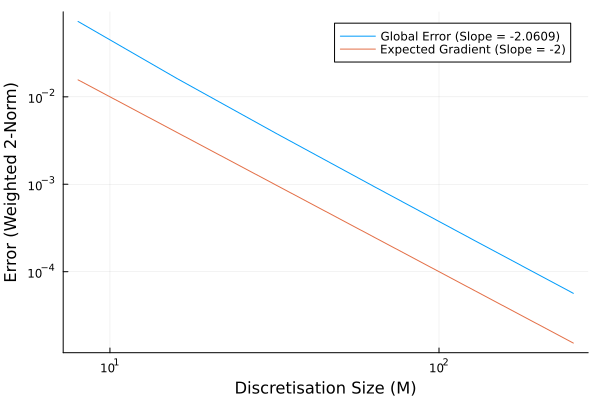

In [9]:
include("../../src/schemes/helmholtz.jl")

begin
    inflate(f, xs, ys) = [f(x,y) for x in xs, y in ys]
        
    x_0 = 0
    x_1 = 3
    y_0 = 0
    y_1 = 3
    Lx = x_1 - x_0
    Ly = y_1 - y_0

    alpha = -3.0
    u(x, y) = sin(2pi * (x) / Lx) * cos(2pi * (y) / Ly)

    # Uxx + Uyy + 3u = f(x, y)
    f(x, y) = -(pi^2)*(u(x,y)*(4/Ly^2 + 4/Lx^2)) + alpha*u(x, y)

    M_list = [8, 16, 32, 64, 128, 256]
    # M_list = 4:2:64
    errors = zeros(size(M_list)[1])

    for (i, M) in enumerate(M_list)
        P = M
        dx = Lx / M

        xs = range(x_0 - dx, x_1, length=M+2)
        ys = range(y_0 - dx, y_1, length=P+2)
        b = inflate(f, xs, ys)
        
        u_num = sp_solve_modified_helmholtz(M, P, dx, b, alpha)
        u_true = inflate(u, xs, ys)

        # Weighted 2-norm.
        errors[i] = dx * norm(u_num - u_true)
    end

    expected_curve(x) = 1/x^2
    ideal_curve = expected_curve.(M_list)

    # Calculate the slope of log-log values to check for second order convergence.
    fit = linear_fit(log.(M_list), log.(errors))
    slope = round(fit[2]; digits=4)

    p = plot(M_list, errors, label="Global Error (Slope = $slope)", xscale=:log10, yscale=:log10, xlabel="Discretisation Size (M)", ylabel="Error (Weighted 2-Norm)")
    plot!(M_list, ideal_curve, label="Expected Gradient (Slope = -2)")
    display(p)
end

## Arakawa Test

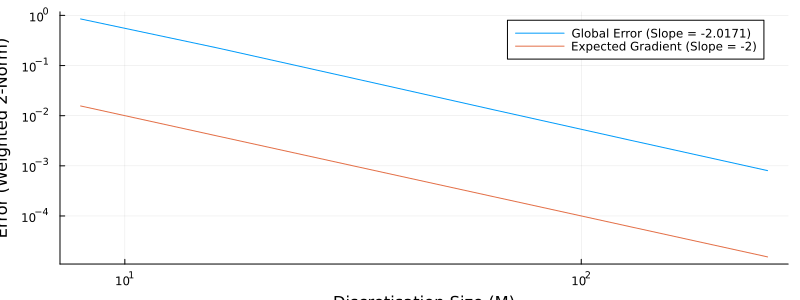

"/Users/jsleadbetter/edinburgh/dissertation/julia-baroclinic/plots/arakawa_validation.png"

In [23]:
include("../../src/schemes/arakawa.jl")

begin
    Lx = 10
    Ly = 10
    A_func(x, y) = sin(2pi*x/Lx)*sin(2pi*y/Ly)
    B_func(x, y) = cos(2pi*x/Lx)*cos(2pi*y/Ly) 
    true_J_func(x, y) = -4pi^2/(Lx*Ly)*cos(2pi*x/Lx)^2*sin(2pi*y/Ly)^2 + 4pi^2/(Lx*Ly)*sin(2pi*x/Lx)^2*cos(2pi*y/Ly)^2 
    
    # M = P = 16
    M_list = [8, 16, 32, 64, 128, 256]
    errors = zeros(size(M_list)[1])

    for (i, M) in enumerate(M_list)
        dx = Lx / M
        P = M

        xs = range(-dx, Lx, length=M+2)
        ys = range(-dx, Ly, length=P+2)
        A = Matrix{Float64}(inflate(A_func, xs, ys))
        B = Matrix{Float64}(inflate(B_func, xs, ys))

        true_J_matrix = inflate(true_J_func, xs, ys)
        test_J_matrix = J(dx, A, B)

        errors[i] = dx * norm(test_J_matrix - true_J_matrix)
    end

    fit = linear_fit(log.(M_list), log.(errors))
    slope = fit[2]

    expected_curve(x) = 1/x^2
    ideal_curve = expected_curve.(M_list)

    # Calculate the slope of log-log values to check for second order convergence.
    fit = linear_fit(log.(M_list), log.(errors))
    slope = round(fit[2]; digits=4)

    p = plot(
        M_list, errors, label="Global Error (Slope = $slope)", xscale=:log10, yscale=:log10,
        xlabel="Discretisation Size (M)", ylabel="Error (Weighted 2-Norm)",
        size=(800, 300)
    )
    plot!(M_list, ideal_curve, label="Expected Gradient (Slope = -2)")
    display(p)

    savefig(p, "../../plots/arakawa_validation.png")
end